In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import json
import numpy as np
import argparse
import torch
import sys
import importlib as ipb
import pickle
import torch.nn as nn
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
def get_mean(result_dict, stop_epoch, return_full=False):
    # Stop_epoch: determine when to stop computing the values.
    full_res = [np.array(i)[:stop_epoch] for i in result_dict.values()]
    if return_full:
        full_mean = np.round(100*np.mean(full_res, axis=0), 2)
        full_std = np.round(100*np.std(full_res, axis=0), 2)
        return [full_mean, full_std]  # For plot
    else:
        idx = [np.argmax(i[:, 1])
               for i in full_res]  # Collect idx at which valid is highest
        vals = [i[j] for i, j in zip(full_res, idx)]
        means = np.round(100*np.mean(vals, axis=0), decimals=2)
        stds = np.round(100*np.std(vals, axis=0), decimals=2)
        return [means, stds]  # For table

In [6]:
def plot_correct_split(key_SVI, key_SVI_Adam, key_SGD, key_Adam, model_architect, lr0, FC=False, change_ratio=False, ratio_mult=1, full_epoch=True, return_early=False):
        '''
            full_epoch: Decides if we plot the entire trajectory or just the initial segments
        '''
        result_dict = json.load(open(f'{key_SVI}.json'))
        key_SVI_dict = 'SVI-SGD' if 'warmstart' not in key_SVI else 'SVI_warmstart-SGD'
        key_SVI_Adam_dict = 'SVI-Adam' if 'warmstart' not in key_SVI_Adam else 'SVI_warmstart-Adam'
        results_over_runs_SVI = result_dict[key_SVI_dict][0]
        result_dict = json.load(open(f'{key_SVI_Adam}.json'))
        results_over_runs_SVI_Adam = result_dict[key_SVI_Adam_dict][0]
        result_dict = json.load(open(f'{key_SGD}.json'))
        results_over_runs_SGD = result_dict['SGD'][0]
        result_dict = json.load(open(f'{key_Adam}.json'))
        results_over_runs_Adam = result_dict['Adam'][0]
        stop_epoch = len(results_over_runs_SVI[f'lr={lr0[1:]}@Run1']) if full_epoch else 50
        if return_early:
            results_SVI = get_mean(results_over_runs_SVI, stop_epoch, return_full=False)
            results_SVI_Adam = get_mean(results_over_runs_SVI_Adam, stop_epoch, return_full=False)
            results_SGD = get_mean(results_over_runs_SGD, stop_epoch, return_full=False)
            results_Adam = get_mean(results_over_runs_Adam, stop_epoch, return_full=False)
            # NOTE, they include train test mean and std.
            res_mean = np.concatenate(
                [val[0] for val in [results_SVI, results_SGD, results_SVI_Adam, results_Adam]])
            res_std = np.concatenate(
                [val[1] for val in [results_SVI, results_SGD, results_SVI_Adam,  results_Adam]])
            return [res_mean, res_std]
        else:
            results_SVI = get_mean(results_over_runs_SVI, stop_epoch, return_full=True)
            results_SVI_Adam = get_mean(results_over_runs_SVI_Adam, stop_epoch, return_full=True)
            results_SGD = get_mean(results_over_runs_SGD, stop_epoch, return_full=True)
            results_Adam = get_mean(results_over_runs_Adam, stop_epoch, return_full=True)
            res_orig = [results_over_runs_SVI, results_over_runs_SGD,
                        results_over_runs_SVI_Adam, results_over_runs_Adam]
            fig, ax = plt.subplots(1, 4, figsize=(36, 5), sharey=True, sharex=True)
            mtd_dict = {0: 'SVI-SGD', 1: 'SGD', 2: 'SVI-Adam', 3: 'Adam'}
            type_dict = {0: 'Train', 1: 'Valid', 2: 'Test'}
            print(f'LR={lr0[1:]} up to {stop_epoch} epochs')
            for i, result in enumerate([results_SVI, results_SGD, results_SVI_Adam, results_Adam]):
                res_mean, res_std = result
                res_mean_final, res_std_final = get_mean(res_orig[i], stop_epoch, return_full=False)
                for j in range(3):  # Train, Valid, Test
                    ax[i].plot(res_mean[:, j], label=type_dict[j])
                    ax[i].fill_between(np.arange(stop_epoch), res_mean[:, j]-res_std[:, j],
                                       res_mean[:, j]+res_std[:, j], alpha=0.3)
                    if j == 0:
                        print(mtd_dict[i])
                    ax[i].set_title(
                        f'{mtd_dict[i]} Final Train {res_mean_final[0]}'+r'$\pm$'+f'{res_std_final[0]}'+f', \n Valid: {res_mean_final[1]}'+r'$\pm$'+f'{res_std_final[1]}'+f', Test: {res_mean_final[2]}'+r'$\pm$'+f'{res_std_final[2]}',
                        fontsize = 30)
                    ax[i].legend(loc='lower right', ncol=3, fontsize=24)
                    ax[i].grid(True)
                    ax[i].tick_params(axis='both', which='major', labelsize=22)
            fig.tight_layout()
            full_e = '' if full_epoch else '_sub_epoch'
            fc_use = '-FC' if FC else ''
            c_ratio = '-change_ratio' if change_ratio else ''
            ratio = ratio_mult if ratio_mult < 1 else ''
            warm_or_not = '_warmstart' if 'warmstart' in key_SVI else ''
            fig.savefig(f'SVI{warm_or_not}_SGD_Adam_vs_SGD_Adam{model_architect}{lr0}LR{full_e}{fc_use}{c_ratio}{ratio}_correct_split.png',
                        dpi=100, bbox_inches='tight', pad_inches=0)
            plt.show()

## Table & Plot of comparisons

### 128 nodes, 0.001 lr (warm start is the best in SVI-SGD and SVI-Adam)    

#### No warm start

In [10]:
# First make summary tables over LR.
# See Table 1 of Rebuttal
model_architect = '-4layers-128nodes'
lrs=['-0.001']
# NOTE: first 12 includes mean values and the rest for std.
full_result = np.zeros((len(lrs), 24))
full_result_sub = np.zeros((len(lrs), 24))
for i, lr0 in enumerate(lrs):
    key_SVI = f'SVI-SGD{model_architect}{lr0}LR_correct_split_loss_together'
    key_SVI_Adam = f'SVI-Adam{model_architect}{lr0}LR_correct_split_loss_together'
    key_SGD = f'SGD{model_architect}{lr0}LR_correct_split'
    key_Adam = f'Adam{model_architect}{lr0}LR_correct_split'
    full_result[i] = np.concatenate(plot_correct_split(key_SVI, key_SVI_Adam, key_SGD, key_Adam,
                                                        model_architect, lr0, full_epoch=True, return_early=True))
    full_result_sub[i] = np.concatenate(plot_correct_split(key_SVI, key_SVI_Adam, key_SGD, key_Adam,
                                                            model_architect, lr0, full_epoch=False, return_early=True))
full_tmp = np.zeros((len(lrs), 12), dtype=object)
full_tmp_sub = np.zeros((len(lrs), 12), dtype=object)
for i in range(len(lrs)):
    for j in range(12):
        full_tmp[i, j] = f'{full_result[i, j]} ({full_result[i, 12+j]})'
        full_tmp_sub[i, j] = f'{full_result_sub[i, j]} ({full_result_sub[i, 12+j]})'
full_result = full_tmp
full_result_sub = full_tmp_sub
mtds = ['SVI-SGD', 'SGD', 'SVI-Adam', 'Adam']
type = ['Train', 'Valid', 'Test']
tuples = list(zip(*[np.repeat(mtds, 3), np.tile(type, 4)]))
index = pd.MultiIndex.from_tuples(tuples)
lr_names = [lr[1:] for lr in lrs]
full_result = pd.DataFrame(full_result, index=lr_names, columns=index)  # Index are LRs
print('Result over all epochs')
print(full_result)
print(full_result.to_latex())
print('##########################')
print('Result over initial epochs')
full_result_sub = pd.DataFrame(full_result_sub, index=lr_names, columns=index)  # Index are LRs
print(full_result_sub)
print(full_result_sub.to_latex())

Result over all epochs
            SVI-SGD                                      SGD                \
              Train        Valid          Test         Train         Valid   
0.001  66.61 (0.11)  67.5 (0.14)  66.56 (0.41)  64.35 (0.19)  65.85 (0.17)   

                         SVI-Adam                                     Adam  \
               Test         Train         Valid          Test        Train   
0.001  65.27 (0.39)  75.11 (0.41)  71.42 (0.07)  70.49 (0.09)  75.6 (0.66)   

                                   
              Valid          Test  
0.001  71.44 (0.22)  69.98 (0.41)  
\begin{tabular}{lllllllllllll}
\toprule
{} & \multicolumn{3}{l}{SVI-SGD} & \multicolumn{3}{l}{SGD} & \multicolumn{3}{l}{SVI-Adam} & \multicolumn{3}{l}{Adam} \\
{} &         Train &        Valid &          Test &         Train &         Valid &          Test &         Train &         Valid &          Test &        Train &         Valid &          Test \\
\midrule
0.001 &  66.61 (0.11) &  67.5 (0.1

/tmp/ipykernel_2138/3294204813.py:33: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(full_result.to_latex())
/tmp/ipykernel_2138/3294204813.py:38: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(full_result_sub.to_latex())


LR=0.001 up to 500 epochs
SVI-SGD
SGD
SVI-Adam
Adam


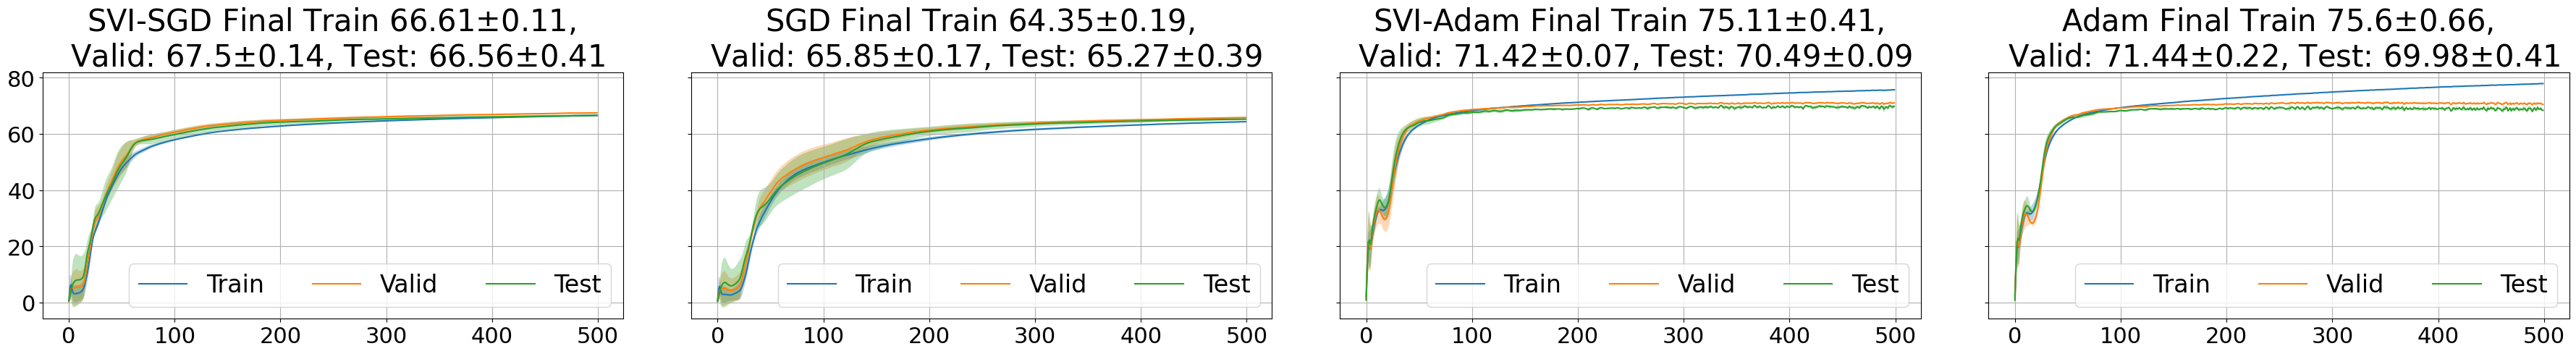

LR=0.001 up to 50 epochs
SVI-SGD
SGD
SVI-Adam
Adam


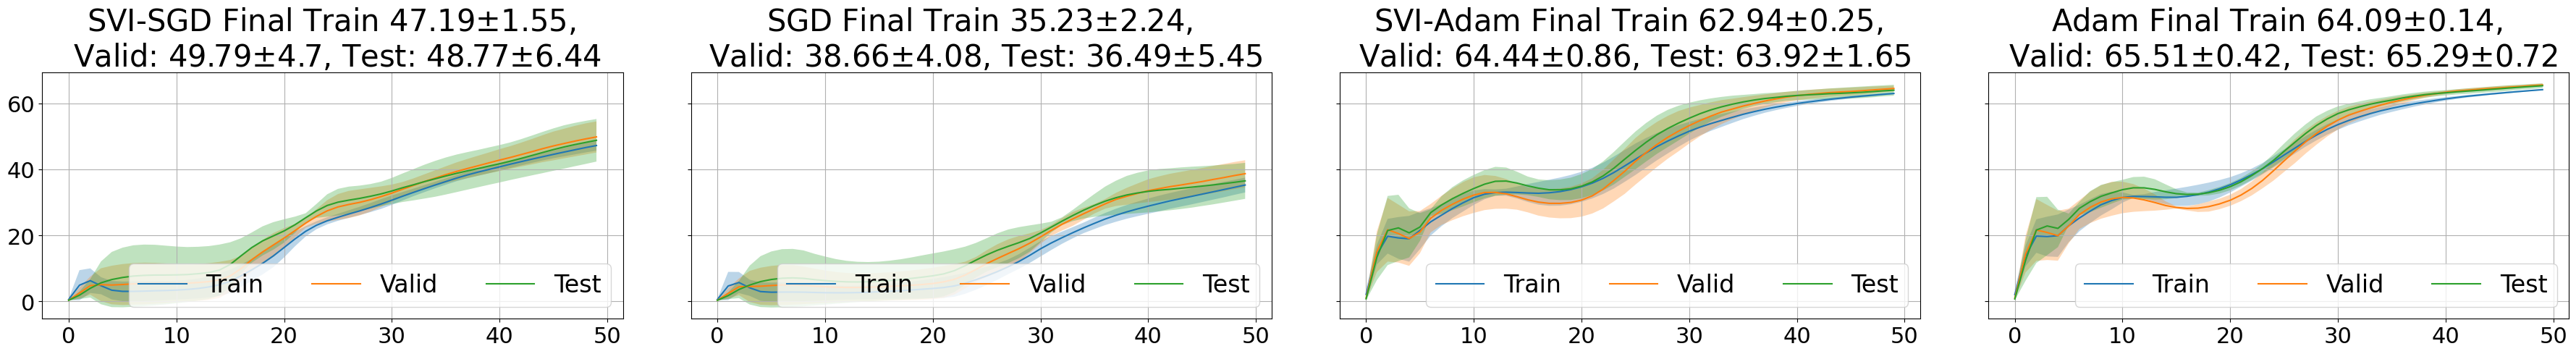

In [11]:
# Then make detailed plots. ONLY at non-FC model (FC=False) and no change in train size (change_ratio=False). 
# See Figure 1 of rebuttal
model_architect='-4layers-128nodes'
lrs=['-0.001']
FC,change_ratio=False,False
fc_use='-FC' if FC else ''
c_ratio='-change_ratio' if change_ratio else ''
for lr0 in lrs:
    key_SVI = f'SVI-SGD{model_architect}{lr0}LR{fc_use}{c_ratio}_correct_split_loss_together'
    key_SVI_Adam = f'SVI-Adam{model_architect}{lr0}LR{fc_use}{c_ratio}_correct_split_loss_together'
    key_SGD = f'SGD{model_architect}{lr0}LR{fc_use}{c_ratio}_correct_split'
    key_Adam = f'Adam{model_architect}{lr0}LR{fc_use}{c_ratio}_correct_split'
    plot_correct_split(key_SVI, key_SVI_Adam, key_SGD, key_Adam, model_architect, lr0, FC, change_ratio,full_epoch=True)
    plot_correct_split(key_SVI, key_SVI_Adam, key_SGD, key_Adam, model_architect, lr0, FC, change_ratio,full_epoch=False)

#### Warm start

In [ ]:
# First make summary tables over LR.
# See Table 1 of Rebuttal
model_architect = '-4layers-128nodes'
lrs=['-0.001']
# NOTE: first 12 includes mean values and the rest for std.
full_result = np.zeros((len(lrs), 24))
full_result_sub = np.zeros((len(lrs), 24))
for i, lr0 in enumerate(lrs):
    key_SVI = f'SVI_warmstart-SGD{model_architect}{lr0}LR_correct_split_loss_together'
    key_SVI_Adam = f'SVI_warmstart-Adam{model_architect}{lr0}LR_correct_split_loss_together'
    key_SGD = f'SGD{model_architect}{lr0}LR_correct_split'
    key_Adam = f'Adam{model_architect}{lr0}LR_correct_split'
    full_result[i] = np.concatenate(plot_correct_split(key_SVI, key_SVI_Adam, key_SGD, key_Adam,
                                                        model_architect, lr0, full_epoch=True, return_early=True))
    full_result_sub[i] = np.concatenate(plot_correct_split(key_SVI, key_SVI_Adam, key_SGD, key_Adam,
                                                            model_architect, lr0, full_epoch=False, return_early=True))
full_tmp = np.zeros((len(lrs), 12), dtype=object)
full_tmp_sub = np.zeros((len(lrs), 12), dtype=object)
for i in range(len(lrs)):
    for j in range(12):
        full_tmp[i, j] = f'{full_result[i, j]} ({full_result[i, 12+j]})'
        full_tmp_sub[i, j] = f'{full_result_sub[i, j]} ({full_result_sub[i, 12+j]})'
full_result = full_tmp
full_result_sub = full_tmp_sub
mtds = ['SVI_warmstart-SGD', 'SGD', 'SVI_warmstart-Adam', 'Adam']
type = ['Train', 'Valid', 'Test']
tuples = list(zip(*[np.repeat(mtds, 3), np.tile(type, 4)]))
index = pd.MultiIndex.from_tuples(tuples)
lr_names = [lr[1:] for lr in lrs]
full_result = pd.DataFrame(full_result, index=lr_names, columns=index)  # Index are LRs
print('Result over all epochs')
print(full_result)
print(full_result.to_latex())
print('##########################')
print('Result over initial epochs')
full_result_sub = pd.DataFrame(full_result_sub, index=lr_names, columns=index)  # Index are LRs
print(full_result_sub)
print(full_result_sub.to_latex())

Result over all epochs
      SVI_warmstart-SGD                                       SGD  \
                  Train         Valid          Test         Train   
0.001       77.3 (0.29)  71.65 (0.12)  70.53 (0.18)  64.35 (0.19)   

                                  SVI_warmstart-Adam                \
              Valid          Test              Train         Valid   
0.001  65.85 (0.17)  65.27 (0.39)        77.57 (1.6)  71.62 (0.22)   

                           Adam                              
              Test        Train         Valid          Test  
0.001  70.52 (0.3)  75.6 (0.66)  71.44 (0.22)  69.98 (0.41)  
\begin{tabular}{lllllllllllll}
\toprule
{} & \multicolumn{3}{l}{SVI\_warmstart-SGD} & \multicolumn{3}{l}{SGD} & \multicolumn{3}{l}{SVI\_warmstart-Adam} & \multicolumn{3}{l}{Adam} \\
{} &             Train &         Valid &          Test &         Train &         Valid &          Test &              Train &         Valid &         Test &        Train &         Valid &   

/tmp/ipykernel_2138/1929733160.py:33: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(full_result.to_latex())
/tmp/ipykernel_2138/1929733160.py:38: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(full_result_sub.to_latex())


LR=0.001 up to 500 epochs
SVI-SGD
SGD
SVI-Adam
Adam


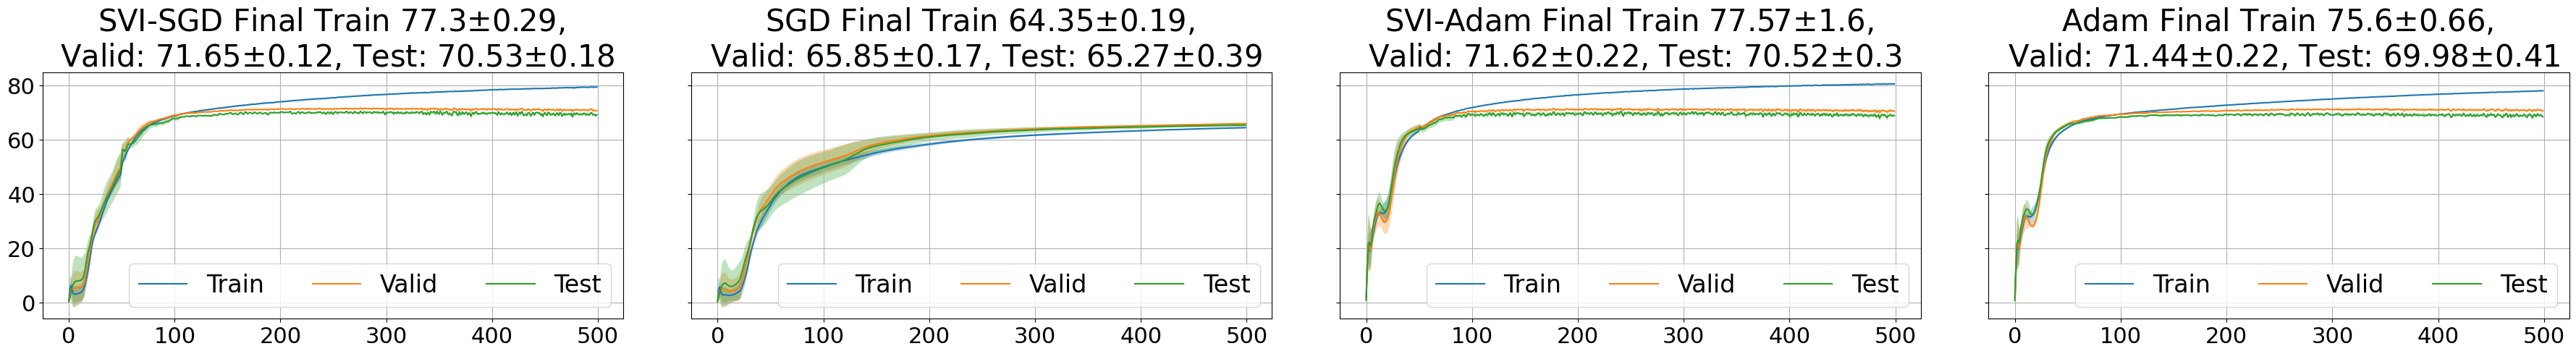

LR=0.001 up to 50 epochs
SVI-SGD
SGD
SVI-Adam
Adam


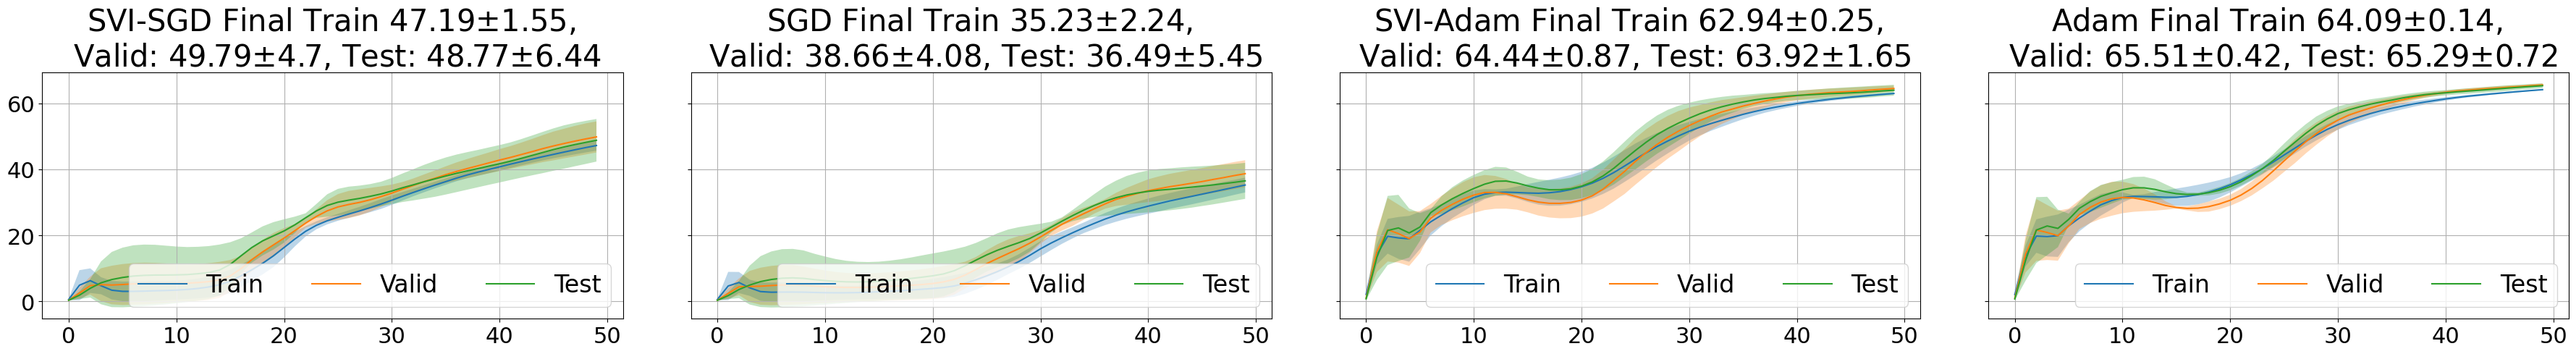

In [ ]:
# Then make detailed plots. ONLY at non-FC model (FC=False) and no change in train size (change_ratio=False). 
# See Figure 1 of rebuttal
model_architect='-4layers-128nodes'
lrs=['-0.001']
FC,change_ratio=False,False
fc_use='-FC' if FC else ''
c_ratio='-change_ratio' if change_ratio else ''
for lr0 in lrs:
    key_SVI = f'SVI_warmstart-SGD{model_architect}{lr0}LR{fc_use}{c_ratio}_correct_split_loss_together'
    key_SVI_Adam = f'SVI_warmstart-Adam{model_architect}{lr0}LR{fc_use}{c_ratio}_correct_split_loss_together'
    key_SGD = f'SGD{model_architect}{lr0}LR{fc_use}{c_ratio}_correct_split'
    key_Adam = f'Adam{model_architect}{lr0}LR{fc_use}{c_ratio}_correct_split'
    plot_correct_split(key_SVI, key_SVI_Adam, key_SGD, key_Adam, model_architect, lr0, FC, change_ratio,full_epoch=True)
    plot_correct_split(key_SVI, key_SVI_Adam, key_SGD, key_Adam, model_architect, lr0, FC, change_ratio,full_epoch=False)

### 256 nodes, 0.001 lr (warm start is the best in SVI-SGD and SVI-Adam)    

#### No warm start

In [15]:
# First make summary tables over LR.
# See Table 1 of Rebuttal
model_architect = '-4layers-256nodes'
lrs=['-0.001']
# NOTE: first 12 includes mean values and the rest for std.
full_result = np.zeros((len(lrs), 24))
full_result_sub = np.zeros((len(lrs), 24))
for i, lr0 in enumerate(lrs):
    key_SVI = f'SVI-SGD{model_architect}{lr0}LR_correct_split'
    key_SVI_Adam = f'SVI-Adam{model_architect}{lr0}LR_correct_split'
    key_SGD = f'SGD{model_architect}{lr0}LR_correct_split'
    key_Adam = f'Adam{model_architect}{lr0}LR_correct_split'
    full_result[i] = np.concatenate(plot_correct_split(key_SVI, key_SVI_Adam, key_SGD, key_Adam,
                                                        model_architect, lr0, full_epoch=True, return_early=True))
    full_result_sub[i] = np.concatenate(plot_correct_split(key_SVI, key_SVI_Adam, key_SGD, key_Adam,
                                                            model_architect, lr0, full_epoch=False, return_early=True))
full_tmp = np.zeros((len(lrs), 12), dtype=object)
full_tmp_sub = np.zeros((len(lrs), 12), dtype=object)
for i in range(len(lrs)):
    for j in range(12):
        full_tmp[i, j] = f'{full_result[i, j]} ({full_result[i, 12+j]})'
        full_tmp_sub[i, j] = f'{full_result_sub[i, j]} ({full_result_sub[i, 12+j]})'
full_result = full_tmp
full_result_sub = full_tmp_sub
mtds = ['SVI-SGD', 'SGD', 'SVI-Adam', 'Adam']
type = ['Train', 'Valid', 'Test']
tuples = list(zip(*[np.repeat(mtds, 3), np.tile(type, 4)]))
index = pd.MultiIndex.from_tuples(tuples)
lr_names = [lr[1:] for lr in lrs]
full_result = pd.DataFrame(full_result, index=lr_names, columns=index)  # Index are LRs
print('Result over all epochs')
print(full_result)
print(full_result.to_latex())
print('##########################')
print('Result over initial epochs')
full_result_sub = pd.DataFrame(full_result_sub, index=lr_names, columns=index)  # Index are LRs
print(full_result_sub)
print(full_result_sub.to_latex())

Result over all epochs
            SVI-SGD                                       SGD                \
              Train         Valid          Test         Train         Valid   
0.001  69.35 (0.07)  69.66 (0.11)  68.58 (0.15)  67.72 (0.13)  68.21 (0.12)   

                         SVI-Adam                                     Adam  \
               Test         Train        Valid          Test         Train   
0.001  67.27 (0.23)  76.99 (0.95)  71.6 (0.05)  70.49 (0.38)  78.44 (0.97)   

                                   
              Valid          Test  
0.001  71.94 (0.09)  70.74 (0.38)  
\begin{tabular}{lllllllllllll}
\toprule
{} & \multicolumn{3}{l}{SVI-SGD} & \multicolumn{3}{l}{SGD} & \multicolumn{3}{l}{SVI-Adam} & \multicolumn{3}{l}{Adam} \\
{} &         Train &         Valid &          Test &         Train &         Valid &          Test &         Train &        Valid &          Test &         Train &         Valid &          Test \\
\midrule
0.001 &  69.35 (0.07) &  69.66

/tmp/ipykernel_2138/3405588355.py:33: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(full_result.to_latex())
/tmp/ipykernel_2138/3405588355.py:38: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(full_result_sub.to_latex())


LR=0.001 up to 500 epochs
SVI-SGD
SGD
SVI-Adam
Adam


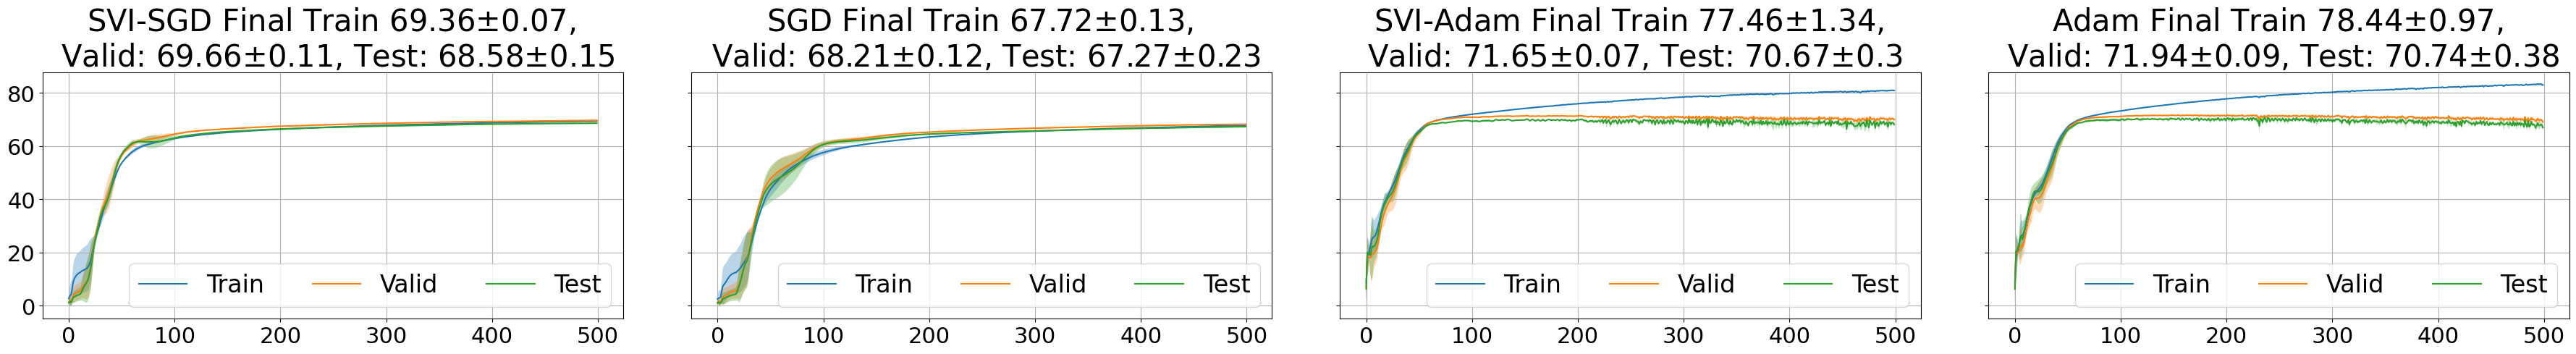

LR=0.001 up to 50 epochs
SVI-SGD
SGD
SVI-Adam
Adam


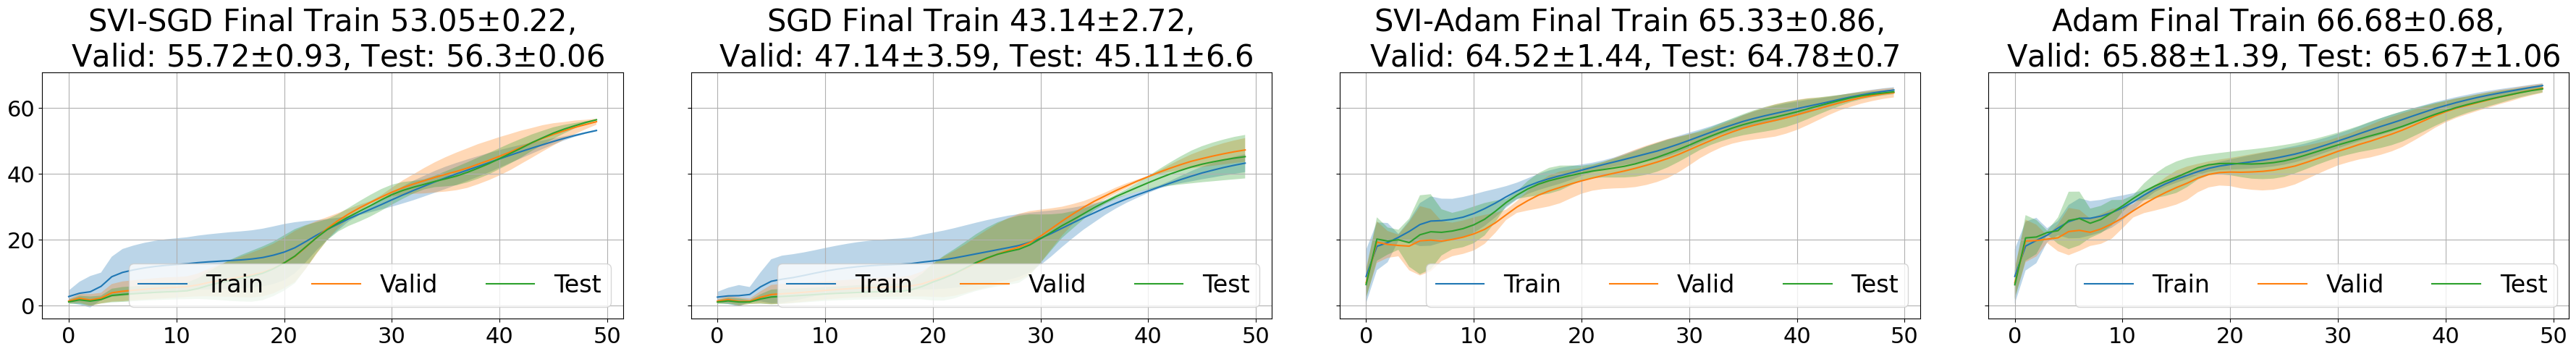

In [16]:
# Then make detailed plots. ONLY at non-FC model (FC=False) and no change in train size (change_ratio=False). 
# See Figure 1 of rebuttal
model_architect='-4layers-256nodes'
lrs=['-0.001']
FC,change_ratio=False,False
fc_use='-FC' if FC else ''
c_ratio='-change_ratio' if change_ratio else ''
for lr0 in lrs:
    key_SVI = f'SVI-SGD{model_architect}{lr0}LR{fc_use}{c_ratio}_correct_split_loss_together'
    key_SVI_Adam = f'SVI-Adam{model_architect}{lr0}LR{fc_use}{c_ratio}_correct_split_loss_together'
    key_SGD = f'SGD{model_architect}{lr0}LR{fc_use}{c_ratio}_correct_split'
    key_Adam = f'Adam{model_architect}{lr0}LR{fc_use}{c_ratio}_correct_split'
    plot_correct_split(key_SVI, key_SVI_Adam, key_SGD, key_Adam, model_architect, lr0, FC, change_ratio,full_epoch=True)
    plot_correct_split(key_SVI, key_SVI_Adam, key_SGD, key_Adam, model_architect, lr0, FC, change_ratio,full_epoch=False)

#### Warm start

In [ ]:
# First make summary tables over LR.
# See Table 1 of Rebuttal
model_architect = '-4layers-256nodes'
lrs=['-0.001']
# NOTE: first 12 includes mean values and the rest for std.
full_result = np.zeros((len(lrs), 24))
full_result_sub = np.zeros((len(lrs), 24))
for i, lr0 in enumerate(lrs):
    key_SVI = f'SVI_warmstart-SGD{model_architect}{lr0}LR_correct_split'
    key_SVI_Adam = f'SVI_warmstart-Adam{model_architect}{lr0}LR_correct_split'
    key_SGD = f'SGD{model_architect}{lr0}LR_correct_split'
    key_Adam = f'Adam{model_architect}{lr0}LR_correct_split'
    full_result[i] = np.concatenate(plot_correct_split(key_SVI, key_SVI_Adam, key_SGD, key_Adam,
                                                        model_architect, lr0, full_epoch=True, return_early=True))
    full_result_sub[i] = np.concatenate(plot_correct_split(key_SVI, key_SVI_Adam, key_SGD, key_Adam,
                                                            model_architect, lr0, full_epoch=False, return_early=True))
full_tmp = np.zeros((len(lrs), 12), dtype=object)
full_tmp_sub = np.zeros((len(lrs), 12), dtype=object)
for i in range(len(lrs)):
    for j in range(12):
        full_tmp[i, j] = f'{full_result[i, j]} ({full_result[i, 12+j]})'
        full_tmp_sub[i, j] = f'{full_result_sub[i, j]} ({full_result_sub[i, 12+j]})'
full_result = full_tmp
full_result_sub = full_tmp_sub
mtds = ['SVI_warmstart-SGD', 'SGD', 'SVI_warmstart-Adam', 'Adam']
type = ['Train', 'Valid', 'Test']
tuples = list(zip(*[np.repeat(mtds, 3), np.tile(type, 4)]))
index = pd.MultiIndex.from_tuples(tuples)
lr_names = [lr[1:] for lr in lrs]
full_result = pd.DataFrame(full_result, index=lr_names, columns=index)  # Index are LRs
print('Result over all epochs')
print(full_result)
print(full_result.to_latex())
print('##########################')
print('Result over initial epochs')
full_result_sub = pd.DataFrame(full_result_sub, index=lr_names, columns=index)  # Index are LRs
print(full_result_sub)
print(full_result_sub.to_latex())

Result over all epochs
      SVI_warmstart-SGD                                     SGD                \
                  Train         Valid        Test         Train         Valid   
0.001      78.84 (0.55)  71.89 (0.08)  70.8 (0.3)  67.72 (0.13)  68.21 (0.12)   

                    SVI_warmstart-Adam                              \
               Test              Train         Valid          Test   
0.001  67.27 (0.23)       77.73 (1.45)  71.69 (0.18)  70.42 (0.46)   

               Adam                              
              Train         Valid          Test  
0.001  78.44 (0.97)  71.94 (0.09)  70.74 (0.38)  
\begin{tabular}{lllllllllllll}
\toprule
{} & \multicolumn{3}{l}{SVI\_warmstart-SGD} & \multicolumn{3}{l}{SGD} & \multicolumn{3}{l}{SVI\_warmstart-Adam} & \multicolumn{3}{l}{Adam} \\
{} &             Train &         Valid &        Test &         Train &         Valid &          Test &              Train &         Valid &          Test &         Train &         Valid &   

/tmp/ipykernel_2138/3400495967.py:33: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(full_result.to_latex())
/tmp/ipykernel_2138/3400495967.py:38: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(full_result_sub.to_latex())


LR=0.001 up to 500 epochs
SVI-SGD
SGD
SVI-Adam
Adam


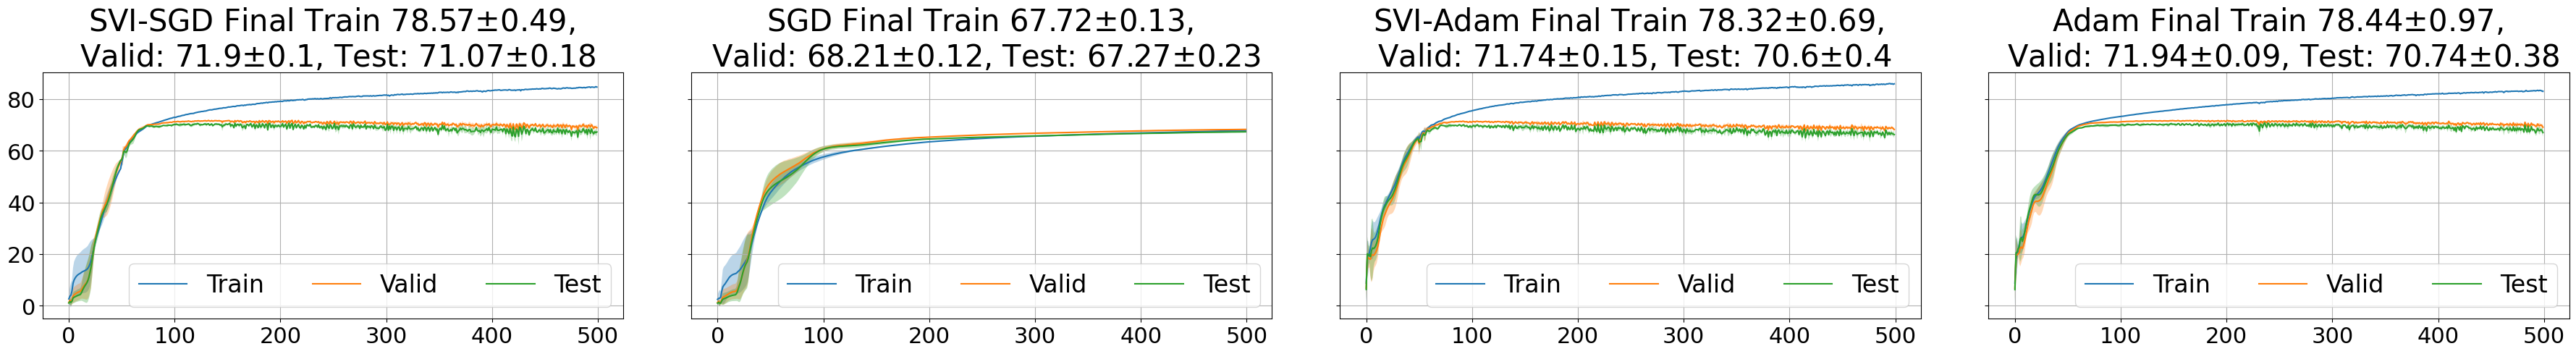

LR=0.001 up to 50 epochs
SVI-SGD
SGD
SVI-Adam
Adam


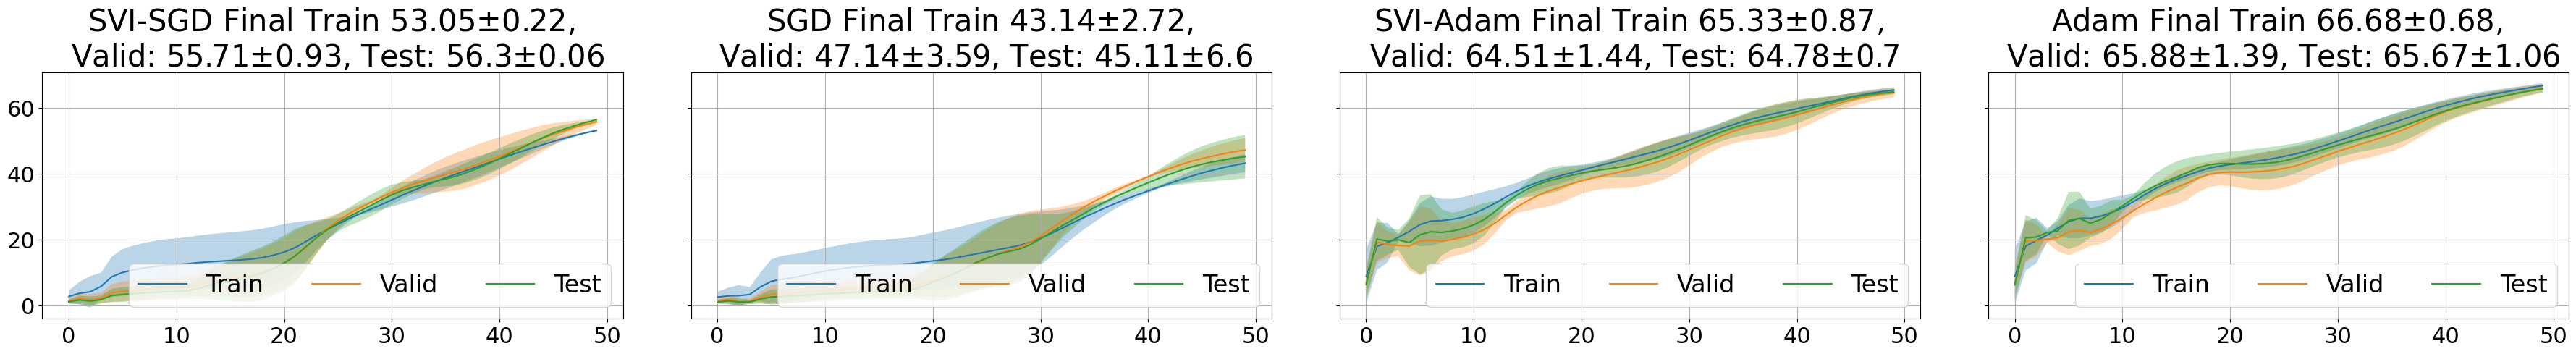

In [ ]:
# Then make detailed plots. ONLY at non-FC model (FC=False) and no change in train size (change_ratio=False). 
# See Figure 1 of rebuttal
model_architect='-4layers-256nodes'
lrs=['-0.001']
FC,change_ratio=False,False
fc_use='-FC' if FC else ''
c_ratio='-change_ratio' if change_ratio else ''
for lr0 in lrs:
    key_SVI = f'SVI_warmstart-SGD{model_architect}{lr0}LR{fc_use}{c_ratio}_correct_split_loss_together'
    key_SVI_Adam = f'SVI_warmstart-Adam{model_architect}{lr0}LR{fc_use}{c_ratio}_correct_split_loss_together'
    key_SGD = f'SGD{model_architect}{lr0}LR{fc_use}{c_ratio}_correct_split'
    key_Adam = f'Adam{model_architect}{lr0}LR{fc_use}{c_ratio}_correct_split'
    plot_correct_split(key_SVI, key_SVI_Adam, key_SGD, key_Adam, model_architect, lr0, FC, change_ratio,full_epoch=True)
    plot_correct_split(key_SVI, key_SVI_Adam, key_SGD, key_Adam, model_architect, lr0, FC, change_ratio,full_epoch=False)

### 512 nodes, 0.001 lr (considered warm start)

#### No warm start

In [19]:
# First make summary tables over LR.
# See Table 1 of Rebuttal
model_architect = '-4layers-512nodes'
lrs=['-0.001']
# NOTE: first 12 includes mean values and the rest for std.
full_result = np.zeros((len(lrs), 24))
full_result_sub = np.zeros((len(lrs), 24))
for i, lr0 in enumerate(lrs):
    key_SVI = f'SVI-SGD{model_architect}{lr0}LR_correct_split_loss_together'
    key_SVI_Adam = f'SVI-Adam{model_architect}{lr0}LR_correct_split_loss_together'
    key_SGD = f'SGD{model_architect}{lr0}LR_correct_split'
    key_Adam = f'Adam{model_architect}{lr0}LR_correct_split'
    full_result[i] = np.concatenate(plot_correct_split(key_SVI, key_SVI_Adam, key_SGD, key_Adam,
                                                        model_architect, lr0, full_epoch=True, return_early=True))
    full_result_sub[i] = np.concatenate(plot_correct_split(key_SVI, key_SVI_Adam, key_SGD, key_Adam,
                                                            model_architect, lr0, full_epoch=False, return_early=True))
full_tmp = np.zeros((len(lrs), 12), dtype=object)
full_tmp_sub = np.zeros((len(lrs), 12), dtype=object)
for i in range(len(lrs)):
    for j in range(12):
        full_tmp[i, j] = f'{full_result[i, j]} ({full_result[i, 12+j]})'
        full_tmp_sub[i, j] = f'{full_result_sub[i, j]} ({full_result_sub[i, 12+j]})'
full_result = full_tmp
full_result_sub = full_tmp_sub
mtds = ['SVI-SGD', 'SGD', 'SVI-Adam', 'Adam']
type = ['Train', 'Valid', 'Test']
tuples = list(zip(*[np.repeat(mtds, 3), np.tile(type, 4)]))
index = pd.MultiIndex.from_tuples(tuples)
lr_names = [lr[1:] for lr in lrs]
full_result = pd.DataFrame(full_result, index=lr_names, columns=index)  # Index are LRs
print('Result over all epochs')
print(full_result)
print(full_result.to_latex())
print('##########################')
print('Result over initial epochs')
full_result_sub = pd.DataFrame(full_result_sub, index=lr_names, columns=index)  # Index are LRs
print(full_result_sub)
print(full_result_sub.to_latex())

Result over all epochs
            SVI-SGD                                     SGD               \
              Train        Valid         Test         Train        Valid   
0.001  71.55 (0.01)  70.5 (0.09)  69.27 (0.1)  70.23 (0.05)  69.63 (0.1)   

                         SVI-Adam                                      Adam  \
               Test         Train         Valid          Test         Train   
0.001  68.29 (0.23)  78.23 (1.05)  71.85 (0.04)  70.87 (0.32)  80.78 (1.05)   

                                   
              Valid          Test  
0.001  71.96 (0.07)  71.03 (0.02)  
\begin{tabular}{lllllllllllll}
\toprule
{} & \multicolumn{3}{l}{SVI-SGD} & \multicolumn{3}{l}{SGD} & \multicolumn{3}{l}{SVI-Adam} & \multicolumn{3}{l}{Adam} \\
{} &         Train &        Valid &         Test &         Train &        Valid &          Test &         Train &         Valid &          Test &         Train &         Valid &          Test \\
\midrule
0.001 &  71.55 (0.01) &  70.5 (0.09) &

/tmp/ipykernel_2138/176015234.py:33: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(full_result.to_latex())
/tmp/ipykernel_2138/176015234.py:38: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(full_result_sub.to_latex())


LR=0.001 up to 500 epochs
SVI-SGD
SGD
SVI-Adam
Adam


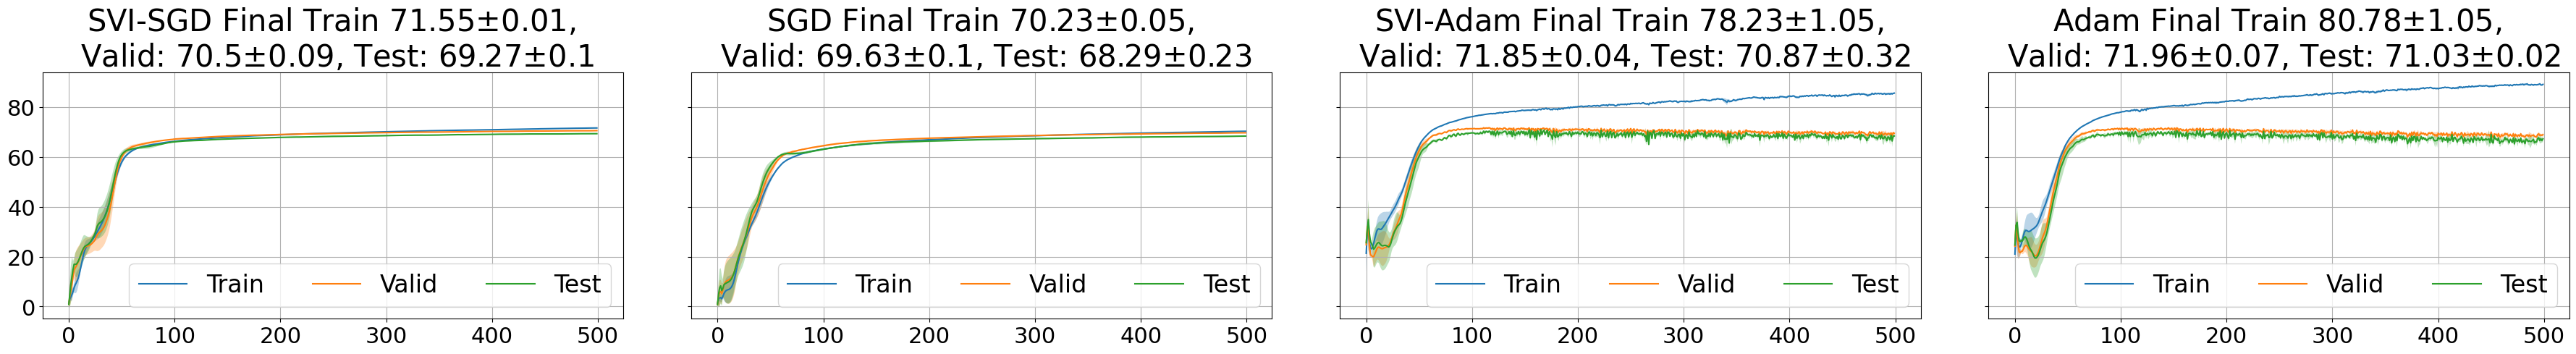

LR=0.001 up to 50 epochs
SVI-SGD
SGD
SVI-Adam
Adam


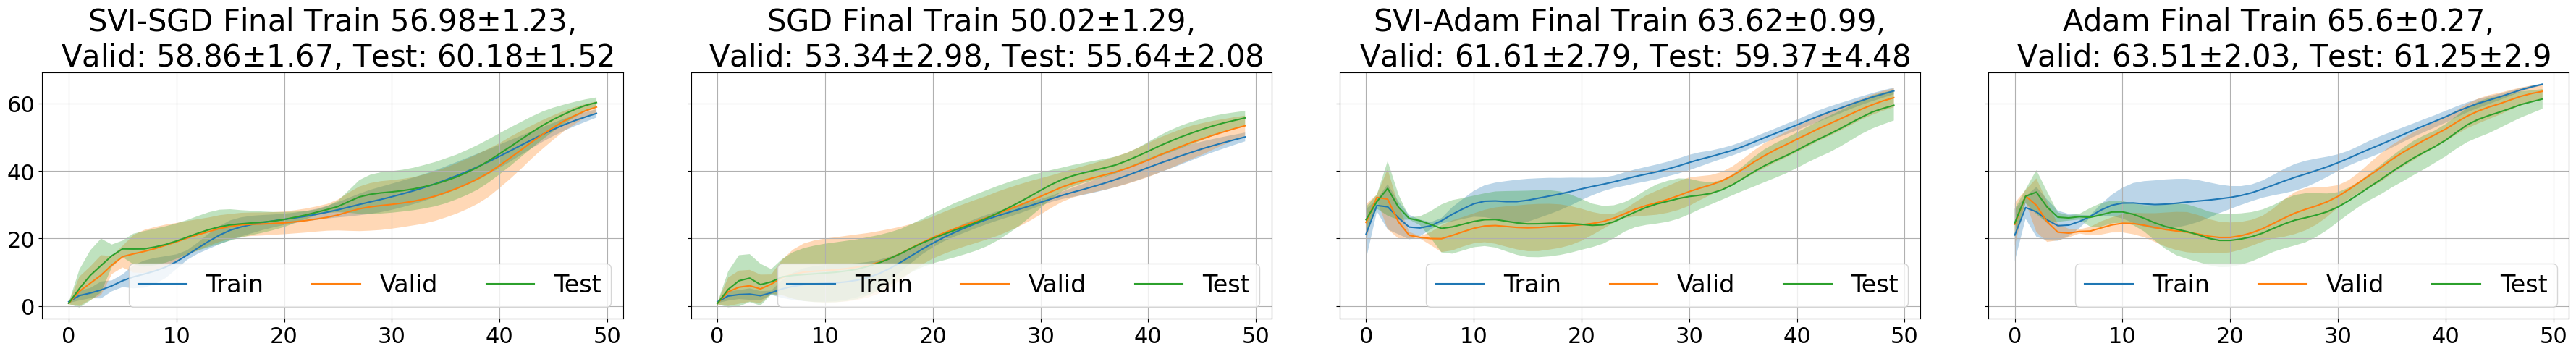

In [20]:
# Then make detailed plots. ONLY at non-FC model (FC=False) and no change in train size (change_ratio=False). 
# See Figure 1 of rebuttal
model_architect='-4layers-512nodes'
lrs=['-0.001']
FC,change_ratio=False,False
fc_use='-FC' if FC else ''
c_ratio='-change_ratio' if change_ratio else ''
for lr0 in lrs:
    key_SVI = f'SVI-SGD{model_architect}{lr0}LR{fc_use}{c_ratio}_correct_split_loss_together'
    key_SVI_Adam = f'SVI-Adam{model_architect}{lr0}LR{fc_use}{c_ratio}_correct_split_loss_together'
    key_SGD = f'SGD{model_architect}{lr0}LR{fc_use}{c_ratio}_correct_split'
    key_Adam = f'Adam{model_architect}{lr0}LR{fc_use}{c_ratio}_correct_split'
    plot_correct_split(key_SVI, key_SVI_Adam, key_SGD, key_Adam, model_architect, lr0, FC, change_ratio,full_epoch=True)
    plot_correct_split(key_SVI, key_SVI_Adam, key_SGD, key_Adam, model_architect, lr0, FC, change_ratio,full_epoch=False)

#### Warm start

In [ ]:
# First make summary tables over LR.
# See Table 1 of Rebuttal
model_architect = '-4layers-512nodes'
lrs=['-0.001']
# NOTE: first 12 includes mean values and the rest for std.
full_result = np.zeros((len(lrs), 24))
full_result_sub = np.zeros((len(lrs), 24))
for i, lr0 in enumerate(lrs):
    key_SVI = f'SVI_warmstart-SGD{model_architect}{lr0}LR_correct_split_loss_together'
    key_SVI_Adam = f'SVI_warmstart-Adam{model_architect}{lr0}LR_correct_split_loss_together'
    key_SGD = f'SGD{model_architect}{lr0}LR_correct_split'
    key_Adam = f'Adam{model_architect}{lr0}LR_correct_split'
    full_result[i] = np.concatenate(plot_correct_split(key_SVI, key_SVI_Adam, key_SGD, key_Adam,
                                                        model_architect, lr0, full_epoch=True, return_early=True))
    full_result_sub[i] = np.concatenate(plot_correct_split(key_SVI, key_SVI_Adam, key_SGD, key_Adam,
                                                            model_architect, lr0, full_epoch=False, return_early=True))
full_tmp = np.zeros((len(lrs), 12), dtype=object)
full_tmp_sub = np.zeros((len(lrs), 12), dtype=object)
for i in range(len(lrs)):
    for j in range(12):
        full_tmp[i, j] = f'{full_result[i, j]} ({full_result[i, 12+j]})'
        full_tmp_sub[i, j] = f'{full_result_sub[i, j]} ({full_result_sub[i, 12+j]})'
full_result = full_tmp
full_result_sub = full_tmp_sub
mtds = ['SVI_warmstart-SGD', 'SGD', 'SVI_warmstart-Adam', 'Adam']
type = ['Train', 'Valid', 'Test']
tuples = list(zip(*[np.repeat(mtds, 3), np.tile(type, 4)]))
index = pd.MultiIndex.from_tuples(tuples)
lr_names = [lr[1:] for lr in lrs]
full_result = pd.DataFrame(full_result, index=lr_names, columns=index)  # Index are LRs
print('Result over all epochs')
print(full_result)
print(full_result.to_latex())
print('##########################')
print('Result over initial epochs')
full_result_sub = pd.DataFrame(full_result_sub, index=lr_names, columns=index)  # Index are LRs
print(full_result_sub)
print(full_result_sub.to_latex())

Result over all epochs
      SVI_warmstart-SGD                                       SGD  \
                  Train         Valid          Test         Train   
0.001       81.0 (1.51)  71.98 (0.15)  71.16 (0.06)  70.23 (0.05)   

                                 SVI_warmstart-Adam                \
             Valid          Test              Train         Valid   
0.001  69.63 (0.1)  68.29 (0.23)       81.25 (0.96)  71.73 (0.14)   

                             Adam                              
               Test         Train         Valid          Test  
0.001  70.54 (0.38)  80.78 (1.05)  71.96 (0.07)  71.03 (0.02)  
\begin{tabular}{lllllllllllll}
\toprule
{} & \multicolumn{3}{l}{SVI\_warmstart-SGD} & \multicolumn{3}{l}{SGD} & \multicolumn{3}{l}{SVI\_warmstart-Adam} & \multicolumn{3}{l}{Adam} \\
{} &             Train &         Valid &          Test &         Train &        Valid &          Test &              Train &         Valid &          Test &         Train &         Valid 

/tmp/ipykernel_2138/2868235657.py:33: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(full_result.to_latex())
/tmp/ipykernel_2138/2868235657.py:38: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(full_result_sub.to_latex())


LR=0.001 up to 500 epochs
SVI-SGD
SGD
SVI-Adam
Adam


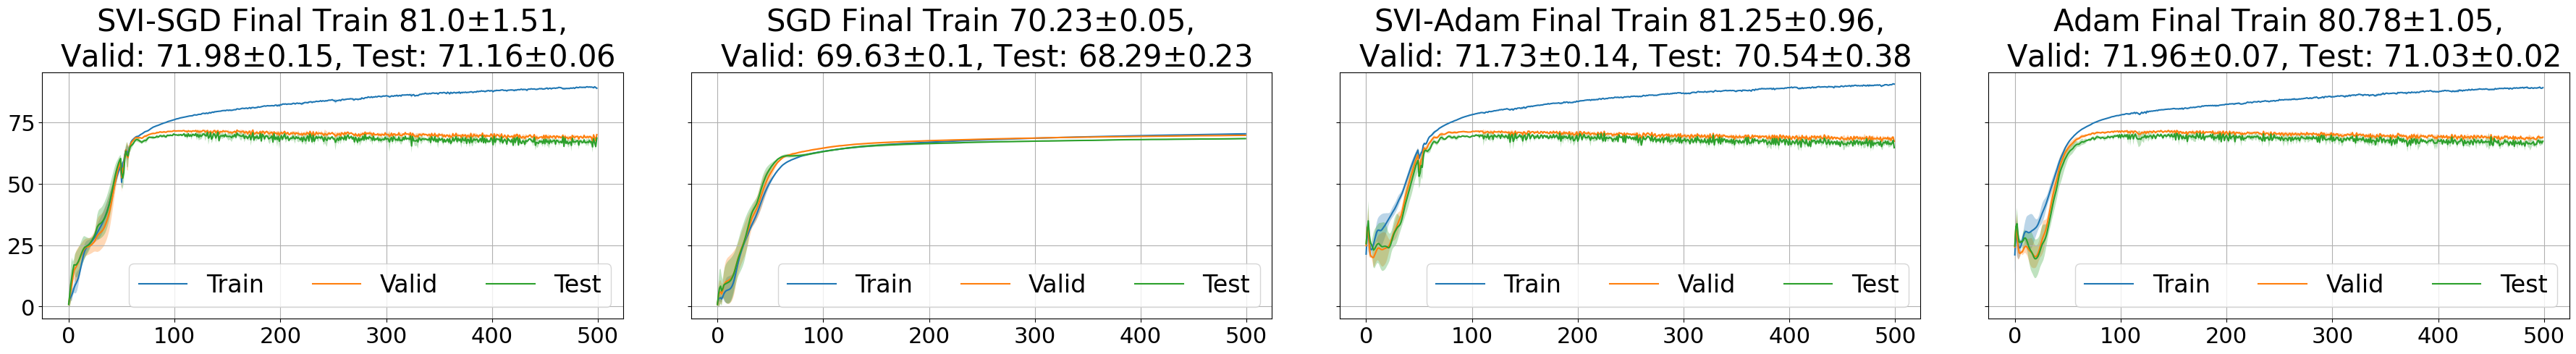

LR=0.001 up to 50 epochs
SVI-SGD
SGD
SVI-Adam
Adam


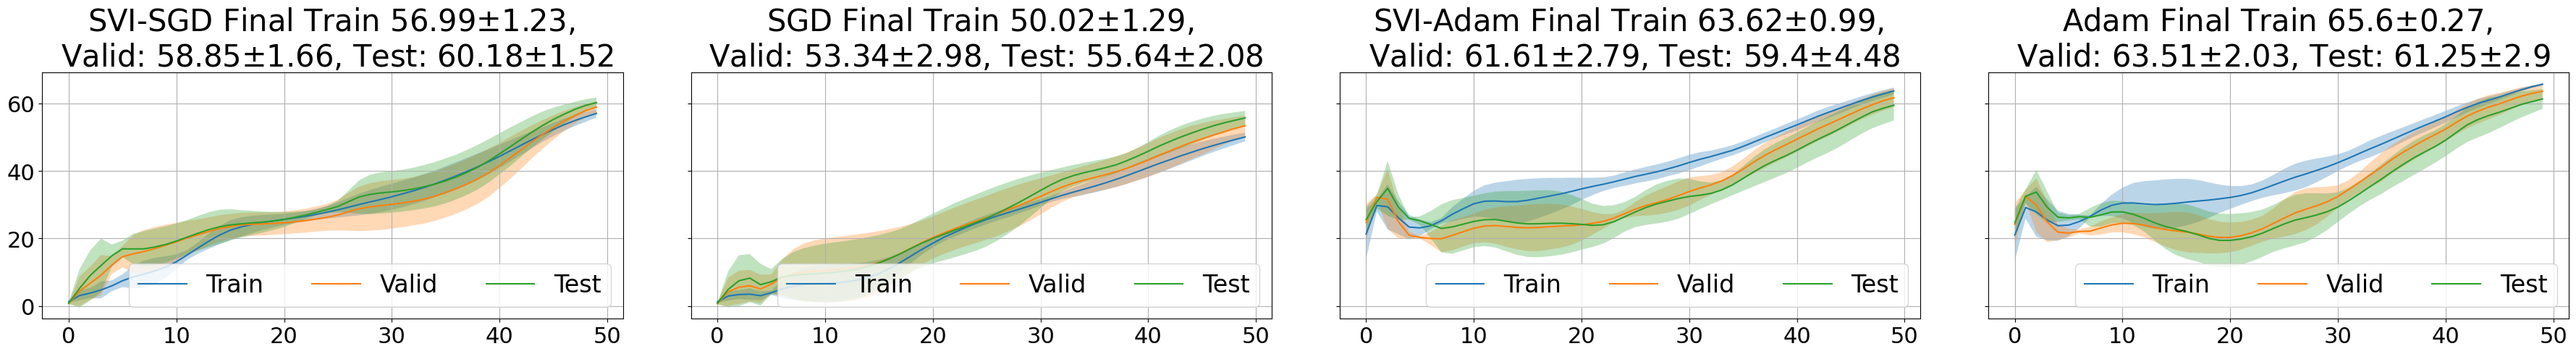

In [ ]:
# Then make detailed plots. ONLY at non-FC model (FC=False) and no change in train size (change_ratio=False). 
# See Figure 1 of rebuttal
model_architect='-4layers-512nodes'
lrs=['-0.001']
FC,change_ratio=False,False
fc_use='-FC' if FC else ''
c_ratio='-change_ratio' if change_ratio else ''
for lr0 in lrs:
    key_SVI = f'SVI_warmstart-SGD{model_architect}{lr0}LR{fc_use}{c_ratio}_correct_split_loss_together'
    key_SVI_Adam = f'SVI_warmstart-Adam{model_architect}{lr0}LR{fc_use}{c_ratio}_correct_split_loss_together'
    key_SGD = f'SGD{model_architect}{lr0}LR{fc_use}{c_ratio}_correct_split'
    key_Adam = f'Adam{model_architect}{lr0}LR{fc_use}{c_ratio}_correct_split'
    plot_correct_split(key_SVI, key_SVI_Adam, key_SGD, key_Adam, model_architect, lr0, FC, change_ratio,full_epoch=True)
    plot_correct_split(key_SVI, key_SVI_Adam, key_SGD, key_Adam, model_architect, lr0, FC, change_ratio,full_epoch=False)